# Nord Security Homeworks

## Introduction
Every day, we consume numerous URLs, each with different reputations and metadata. Various services are responsible for ingesting, curating, and logging these URLs. The goal of this task is to uncover hidden insights in the data, prepare dashboards, and present findings with arguments on potential ways to improve data quality, highlighting potential bottlenecks and service failures.

### Data Overview
The data for this task includes:
- **Reputation:** The trustworthiness of the URL.
- **Date:** When the URL was accessed.
- **Source:** Where the URL originates.
- **Redirection:** Whether the URL redirects to a different one.
- **Service Processed:** Which service processed the URL.
- **Etc.**

## Goals

### Main Goals
- **Analyze the Data**: Identify the most valuable parts of the data that can lead to improved data quality.
  - Check overall statistics of different fields to identify any anomalies.
  - Determine which service deals with the most load time.
  - Find out which source has the most incorrect reputations.
  - Identify which services cause the most redirects.
- **Visualize Findings**: Create and visualize your findings in a dynamic dashboard of your selection.

### Bonus Goals
- **Missing Information**: Implement a solution to fill missing data, such as domain age or response codes.
- **Data Consistency Over Time**:
  - Determine the final information about a URL based on the time and priority of the message.
  - For example, if `test.com` was consumed 3 times with different reputations and dates, the final reputation should be from the latest date unless an earlier message had a higher priority.
  - Address missing information across messages to form a complete, updated record.

## Project Submission
- The project should be uploaded to a git repository (GitHub, GitLab, etc.) and the link should be sent with a README.md file detailing how to navigate the repository.

## Notes for Review
- During the technical interview, be prepared to discuss the methods chosen to solve the problem.
- There are no limitations on the tools used for visualizing the data, but data handling is expected to be done using Python and/or SQL.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from sklearn.impute import KNNImputer
from scipy.stats import chi2_contingency

In [2]:
# Load JSON data
messages = pd.read_json('messages.json')
priority = pd.read_json('priority.json')
reputations = pd.read_json('reputations.json')
true_reputations = pd.read_json('true_reputations.json')

In [3]:
messages

id                 url       date  \
0      e4c75faf-2647-499d-bec0-3602b21c17c4        news.mail.ru 2022-12-11   
1      1a4d5919-5e55-4730-a2b7-dfe46490c03e             rs6.net 2024-02-15   
2      59d6d211-9533-41de-b290-bc996d042b06      postfinance.ch 2020-04-20   
3      1fd98cc8-25f7-4328-8764-21e046214e90           libero.it 2020-05-29   
4      9d2d879a-b9f9-4839-9dab-bd6d96ed8a30          xvideos.es 2022-01-30   
...                                     ...                 ...        ...   
99995  dec66cc6-d46e-4cbf-bc59-5a43231814de  webrootcloudav.com 2020-08-22   
99996  cd45d803-98ef-4838-b785-168c54af7d47        google.co.in 2020-01-21   
99997  23a43737-36ee-4fa9-95f3-911d51bf6598         parsely.com 2020-01-28   
99998  f90c5c71-d083-4576-bbd9-92867bf97b66               vz.ru 2022-07-22   
99999  767bcb6e-2566-4268-b169-9340f20a0396          fandom.com 2022-04-28   

         source protocol  response_code  load_time_seconds  domain_age_years  \
0      source_2     HTTP          200.0               1.87               2.0   
1      source_4     HTTP          200.0               0.59               2.0   
2      source_1    HTTPS          200.0               2.10               1.0   
3      source_1     HTTP          200.0               9.65               2.0   
4      source_4     HTTP          200.0               9.07               1.0   
...         ...      ...            ...                ...               ...   
99995  source_2     HTTP          200.0               8.65               1.0   
99996  source_3     HTTP          200.0               4.94               1.0   
99997  source_4     HTTP          200.0               2.17               NaN   
99998  source_3    HTTPS          200.0               2.80               3.0   
99999  source_3    HTTPS          200.0               6.99               3.0   

       page_size_kb                 redirects    service  
0               252                     False  service_2  
1               179                     False  service_2  
2               252                     False  service_3  
3               308       [True, pandora.com]  service_4  
4                80     [True, pravda.com.ua]  service_3  
...             ...                       ...        ...  
99995           157                     False  service_1  
99996           249        [True, pardot.com]  service_2  
99997           247                     False  service_3  
99998            63                     False  service_2  
99999           466  [True, index.hr, fb.com]  service_1  

[100000 rows x 11 columns]

In [4]:
priority

id   priority  timestamp
0      e81bbb34-b37d-4055-8356-27aa1f179c4d  service_4 2023-12-26
1      5f5d8e39-5539-4503-a07e-a748cc2adffb  service_4 2023-08-28
2      f2667858-92e4-40e7-91e9-df2c32ab4079  service_3 2023-02-26
3      6b99aaf9-847e-45ad-9eb3-8e8448dd0fca  service_3 2020-05-16
4      385c2534-bc68-40f8-985f-d6f39ddb8b9a  service_1 2021-02-03
...                                     ...        ...        ...
99995  a28f7355-2af8-4817-9609-7c3b4da065d4  service_3 2023-08-09
99996  2db12abc-358d-4907-a89d-2ef83e300821  service_3 2021-04-19
99997  2239caeb-28e6-4025-acd1-338edede3058  service_1 2021-09-23
99998  d004b959-175b-4a02-be14-3b44f9a53d19  service_1 2021-05-11
99999  a150a6c2-0d0b-465d-82dd-e20818f76086  service_2 2020-08-25

[100000 rows x 3 columns]

In [5]:
reputations

id reputation_source  \
0      b5ef91f1-2cad-4c68-b150-ab3772f5d998          source_2   
1      a06064f8-71d0-44ee-8630-56a81c5ac16f          source_3   
2      551fa742-7fc5-42d1-88fa-1a93387f0eb2          source_2   
3      99de4aec-7070-4d75-9970-c7d5809b6438          source_3   
4      13d3fbb4-bc17-485c-b4f4-266268c7fe83          source_1   
...                                     ...               ...   
89995  80730929-bc29-4c1f-8c72-4f16f123624b          source_2   
89996  3ab4b851-84ea-4d8f-9861-c87296341753          source_1   
89997  adee1796-d4ec-44cc-ae3b-321e23e175d2          source_3   
89998  b5f87d51-934b-42b5-a2d7-de713803cdb4          source_1   
89999  8f719980-986b-4373-a84c-cb3bb15758c1          source_1   

       reputation_score reputation_category reputation_date  
0                    87             neutral      2023-08-20  
1                    57                good      2024-02-05  
2                    75                good      2021-08-05  
3                    66             neutral      2023-02-22  
4                    70                good      2020-04-19  
...                 ...                 ...             ...  
89995                37                good      2020-09-28  
89996                49                good      2023-05-30  
89997                72                 bad      2023-03-28  
89998                63                good      2023-06-02  
89999                12                good      2024-02-20  

[90000 rows x 5 columns]

In [6]:
true_reputations

id true_reputation reputation_source  \
0      356768e7-eb3c-4b0d-8bdd-975ec605e1ec           clean         service_C   
1      33e1be2d-bc22-4771-ac98-f717714a9b5c           clean         service_A   
2      deac4684-3fcc-4159-800a-988d88af475e         unknown         service_B   
3      50f5f3e8-a3a2-491f-baa2-bf6557ee481a         malware         service_D   
4      dbe9ff6e-18ca-41c3-908f-b50a98f28249           clean         service_D   
...                                     ...             ...               ...   
93329  e0b92ad2-5341-4e84-a119-0abcfa5cbbe3           clean         service_A   
93330  af024c3e-eb78-4f7e-ad2e-9a8931290c87           clean         service_B   
93331  094f9733-4521-41a2-820f-9f8e12c3ee7f           clean         service_B   
93332  46beddb3-6c74-4c34-a792-c73a2ef4b65b           clean         service_C   
93333  85153d1e-202a-4e83-a2ae-ccfdac280fa5           clean         service_A   

       timestamp  
0     2020-06-18  
1     2023-04-13  
2     2020-10-18  
3     2022-07-29  
4     2023-03-09  
...          ...  
93329 2020-11-13  
93330 2020-05-17  
93331 2020-08-27  
93332 2023-12-15  
93333 2022-11-29  

[93334 rows x 4 columns]

# Part I: Initial Data Analysis

## Messages

In [7]:
messages.head()

id             url       date    source  \
0  e4c75faf-2647-499d-bec0-3602b21c17c4    news.mail.ru 2022-12-11  source_2   
1  1a4d5919-5e55-4730-a2b7-dfe46490c03e         rs6.net 2024-02-15  source_4   
2  59d6d211-9533-41de-b290-bc996d042b06  postfinance.ch 2020-04-20  source_1   
3  1fd98cc8-25f7-4328-8764-21e046214e90       libero.it 2020-05-29  source_1   
4  9d2d879a-b9f9-4839-9dab-bd6d96ed8a30      xvideos.es 2022-01-30  source_4   

  protocol  response_code  load_time_seconds  domain_age_years  page_size_kb  \
0     HTTP          200.0               1.87               2.0           252   
1     HTTP          200.0               0.59               2.0           179   
2    HTTPS          200.0               2.10               1.0           252   
3     HTTP          200.0               9.65               2.0           308   
4     HTTP          200.0               9.07               1.0            80   

               redirects    service  
0                  False  service_2  
1                  False  service_2  
2                  False  service_3  
3    [True, pandora.com]  service_4  
4  [True, pravda.com.ua]  service_3

In [8]:
messages.describe()

response_code  load_time_seconds  domain_age_years   page_size_kb
count   98995.000000      100000.000000      74905.000000  100000.000000
mean      223.408202           5.267296          2.001976     275.124990
std        51.554777           2.737244          0.815021     130.370858
min       200.000000           0.500000          1.000000      50.000000
25%       200.000000           2.900000          1.000000     162.000000
50%       200.000000           5.280000          2.000000     275.000000
75%       200.000000           7.640000          3.000000     388.000000
max       404.000000          10.000000          3.000000     500.000000

In [9]:
summary_stats = messages.describe(include='all')

/var/folders/4b/y7ccgm795dqf21zwzxsv9wj00000gn/T/ipykernel_21818/518377500.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  summary_stats = messages.describe(include='all')


In [10]:
summary_stats

id         url                 date  \
count                                 100000      100000               100000   
unique                                100000        2168                 3324   
top     e4c75faf-2647-499d-bec0-3602b21c17c4  bet365.com  2024-02-17 00:00:00   
freq                                       1          70                   93   
first                                    NaN         NaN  1936-01-26 00:00:00   
last                                     NaN         NaN  2024-02-28 00:00:00   
mean                                     NaN         NaN                  NaN   
std                                      NaN         NaN                  NaN   
min                                      NaN         NaN                  NaN   
25%                                      NaN         NaN                  NaN   
50%                                      NaN         NaN                  NaN   
75%                                      NaN         NaN                  NaN   
max                                      NaN         NaN                  NaN   

          source protocol  response_code  load_time_seconds  domain_age_years  \
count     100000   100000   98995.000000      100000.000000      74905.000000   
unique         4        2            NaN                NaN               NaN   
top     source_3     HTTP            NaN                NaN               NaN   
freq       25094    50095            NaN                NaN               NaN   
first        NaN      NaN            NaN                NaN               NaN   
last         NaN      NaN            NaN                NaN               NaN   
mean         NaN      NaN     223.408202           5.267296          2.001976   
std          NaN      NaN      51.554777           2.737244          0.815021   
min          NaN      NaN     200.000000           0.500000          1.000000   
25%          NaN      NaN     200.000000           2.900000          1.000000   
50%          NaN      NaN     200.000000           5.280000          2.000000   
75%          NaN      NaN     200.000000           7.640000          3.000000   
max          NaN      NaN     404.000000          10.000000          3.000000   

         page_size_kb redirects    service  
count   100000.000000    100000     100000  
unique            NaN     12182          4  
top               NaN     False  service_2  
freq              NaN     59967      30118  
first             NaN       NaN        NaN  
last              NaN       NaN        NaN  
mean       275.124990       NaN        NaN  
std        130.370858       NaN        NaN  
min         50.000000       NaN        NaN  
25%        162.000000       NaN        NaN  
50%        275.000000       NaN        NaN  
75%        388.000000       NaN        NaN  
max        500.000000       NaN        NaN

In [11]:
messages.dtypes

id                           object
url                          object
date                 datetime64[ns]
source                       object
protocol                     object
response_code               float64
load_time_seconds           float64
domain_age_years            float64
page_size_kb                  int64
redirects                    object
service                      object
dtype: object

In [12]:
null_counts = messages.isnull().sum()
print(null_counts)

id                       0
url                      0
date                     0
source                   0
protocol                 0
response_code         1005
load_time_seconds        0
domain_age_years     25095
page_size_kb             0
redirects                0
service                  0
dtype: int64


In [13]:
messages[messages['response_code'].isnull()].head()

id            url       date    source  \
38   9db64afb-dfa8-4b40-a970-190bc7968a6b          ad.nl 2024-02-28  source_2   
93   3fdc3539-d60c-49e7-b73c-a5db6c111c3a  google.com.ph 2023-12-11  source_2   
300  16e68df1-e1ac-45be-b2a8-9bf93eb2c667        faz.net 2021-05-03  source_3   
547  53ed04c2-1de7-40ff-ad90-d819ef4a29cd   eltiempo.com 2021-10-29  source_4   
649  c9929e1e-3849-4acb-8fa6-ad1def251c98      media.net 2020-08-11  source_2   

    protocol  response_code  load_time_seconds  domain_age_years  \
38      HTTP            NaN               4.28               2.0   
93     HTTPS            NaN               4.86               NaN   
300     HTTP            NaN               1.67               1.0   
547    HTTPS            NaN               3.39               2.0   
649    HTTPS            NaN               2.96               2.0   

     page_size_kb              redirects    service  
38             96     [True, ecosia.org]  service_2  
93            431                  False  service_1  
300           296                  False  service_2  
547           110  [True, omnitagjs.com]  service_1  
649           348                  False  service_2

In [14]:
messages[messages['domain_age_years'].isnull()].head()

id              url       date  \
7   ab190659-2b1a-4531-9ca5-279beeedc2d1  webpkgcache.com 2022-09-19   
11  e46b2cbe-2f63-4ae5-8f3a-e9f98e7400ff           hm.com 2020-04-25   
14  272ef564-6682-4c78-b3a2-acc219e9b9f3          ign.com 2022-04-07   
15  896e272d-1c57-4265-879f-5e09a68c9de1    vnexpress.net 2020-11-24   
23  7981c8c4-d557-414b-baa0-e450520fdf2f    google.com.ec 2022-03-22   

      source protocol  response_code  load_time_seconds  domain_age_years  \
7   source_4    HTTPS          200.0               5.72               NaN   
11  source_4     HTTP          200.0               7.15               NaN   
14  source_4    HTTPS          200.0               1.02               NaN   
15  source_1     HTTP          200.0               2.15               NaN   
23  source_4     HTTP          200.0               5.48               NaN   

    page_size_kb                              redirects    service  
7            156  [True, fatalmodel.com, cookiepro.com]  service_4  
11           475                     [True, sascdn.com]  service_4  
14           234                                  False  service_2  
15           173                                  False  service_3  
23           238                        [True, chip.de]  service_4

In [15]:
# Filter the DataFrame to include only rows where domain_age_years is null
null_domain_age_urls = messages[messages['domain_age_years'].isnull()]['url']

# Count the number of unique URLs with null domain ages
unique_null_domain_age_urls_count = null_domain_age_urls.nunique()

print("Number of unique URLs with null domain ages:", unique_null_domain_age_urls_count)

Number of unique URLs with null domain ages: 2168


In [16]:
# Group the data by 'url', aggregate the maximum domain age and count of null domain ages, and reset the index
url_stats = messages.groupby('url').agg({'domain_age_years': ['max', lambda x: x.isnull().sum()]}).reset_index()

# Rename the columns for clarity
url_stats.columns = ['url', 'max_domain_age', 'count_null_domain_age']

# Filter rows where count of null domain ages is greater than 0
url_stats = url_stats[url_stats['count_null_domain_age'] > 0]

# Sort the result by count of null domain ages in descending order
url_stats = url_stats.sort_values(by='max_domain_age', ascending=True)

print(url_stats)

                       url  max_domain_age  count_null_domain_age
0                 0hpx.xyz             3.0                     14
1453             onetag.io             3.0                     13
1452        onetag-sys.com             3.0                      8
1451               onet.pl             3.0                     15
1450          onedrive.com             3.0                     11
...                    ...             ...                    ...
715             glpals.com             3.0                     17
714              globo.com             3.0                     11
713         globalsign.net             3.0                      9
727   goodhousekeeping.com             3.0                     12
2167        zscalertwo.net             3.0                      9

[2168 rows x 3 columns]


In [17]:
url_stats[url_stats[('max_domain_age')].isnull()]

Empty DataFrame
Columns: [url, max_domain_age, count_null_domain_age]
Index: []

2168 missing domain_age_years values can be imputed using provided data.

### Filling domain_age_years missing values

In [18]:
# Merge the initial DataFrame (df) with url_stats on the 'url' column
merged_df = pd.merge(messages, url_stats, on='url', how='left')

# Replace missing values in 'domain_age_years' with 'max_domain_age'
merged_df['domain_age_years'].fillna(merged_df['max_domain_age'], inplace=True)

# Drop the additional columns from url_stats
merged_df.drop(['max_domain_age', 'count_null_domain_age'], axis=1, inplace=True)

In [19]:
merged_df

id                 url       date  \
0      e4c75faf-2647-499d-bec0-3602b21c17c4        news.mail.ru 2022-12-11   
1      1a4d5919-5e55-4730-a2b7-dfe46490c03e             rs6.net 2024-02-15   
2      59d6d211-9533-41de-b290-bc996d042b06      postfinance.ch 2020-04-20   
3      1fd98cc8-25f7-4328-8764-21e046214e90           libero.it 2020-05-29   
4      9d2d879a-b9f9-4839-9dab-bd6d96ed8a30          xvideos.es 2022-01-30   
...                                     ...                 ...        ...   
99995  dec66cc6-d46e-4cbf-bc59-5a43231814de  webrootcloudav.com 2020-08-22   
99996  cd45d803-98ef-4838-b785-168c54af7d47        google.co.in 2020-01-21   
99997  23a43737-36ee-4fa9-95f3-911d51bf6598         parsely.com 2020-01-28   
99998  f90c5c71-d083-4576-bbd9-92867bf97b66               vz.ru 2022-07-22   
99999  767bcb6e-2566-4268-b169-9340f20a0396          fandom.com 2022-04-28   

         source protocol  response_code  load_time_seconds  domain_age_years  \
0      source_2     HTTP          200.0               1.87               2.0   
1      source_4     HTTP          200.0               0.59               2.0   
2      source_1    HTTPS          200.0               2.10               1.0   
3      source_1     HTTP          200.0               9.65               2.0   
4      source_4     HTTP          200.0               9.07               1.0   
...         ...      ...            ...                ...               ...   
99995  source_2     HTTP          200.0               8.65               1.0   
99996  source_3     HTTP          200.0               4.94               1.0   
99997  source_4     HTTP          200.0               2.17               3.0   
99998  source_3    HTTPS          200.0               2.80               3.0   
99999  source_3    HTTPS          200.0               6.99               3.0   

       page_size_kb                 redirects    service  
0               252                     False  service_2  
1               179                     False  service_2  
2               252                     False  service_3  
3               308       [True, pandora.com]  service_4  
4                80     [True, pravda.com.ua]  service_3  
...             ...                       ...        ...  
99995           157                     False  service_1  
99996           249        [True, pardot.com]  service_2  
99997           247                     False  service_3  
99998            63                     False  service_2  
99999           466  [True, index.hr, fb.com]  service_1  

[100000 rows x 11 columns]

In [20]:
null_counts = merged_df.isnull().sum()
print(null_counts)

id                      0
url                     0
date                    0
source                  0
protocol                0
response_code        1005
load_time_seconds       0
domain_age_years        0
page_size_kb            0
redirects               0
service                 0
dtype: int64


### Note: 

After imputing values of maximum domain age, I realized that this approach was not optimal because the data is timeline-based. It would have been better to create a matrix for URLs and dates, and to fill in the years accordingly, then impute values while taking the message date into account.

However, as I reviewed data for a specific domain, I observed that the `domain_age_years` values were not entirely accurate - for the same year, there were values like 1, 2, and 3. Thus, preparing the mentioned matrix would be difficult, and analyzing how domain age, for example, impacted reputation, would not be feasible.

### Filling response_code missing values

In [21]:
# Create a mask of the original NaN values
missing_mask = merged_df['response_code'].isna()

In [22]:
# Define and perform the imputation
imputer = KNNImputer(n_neighbors=5)
imputed_values = imputer.fit_transform(merged_df[['response_code']])

# Map imputed values to the nearest valid code
valid_codes = np.array([200.0, 301.0, 404.0])
vectorized_find_nearest = np.vectorize(lambda val: valid_codes[np.abs(valid_codes - val).argmin()])
rounded_values = vectorized_find_nearest(imputed_values)

# Update the DataFrame only where values were originally missing
merged_df.loc[missing_mask, 'response_code'] = rounded_values[missing_mask]

In [23]:
# Count occurrences of each response code in the imputed data
imputed_counts = merged_df.loc[missing_mask, 'response_code'].value_counts()
print(imputed_counts)

200.0    1005
Name: response_code, dtype: int64


It looks that same results could be reached simply by using most frequent value (200.0).

In [24]:
null_counts = merged_df.isnull().sum()
print(null_counts)

id                   0
url                  0
date                 0
source               0
protocol             0
response_code        0
load_time_seconds    0
domain_age_years     0
page_size_kb         0
redirects            0
service              0
dtype: int64


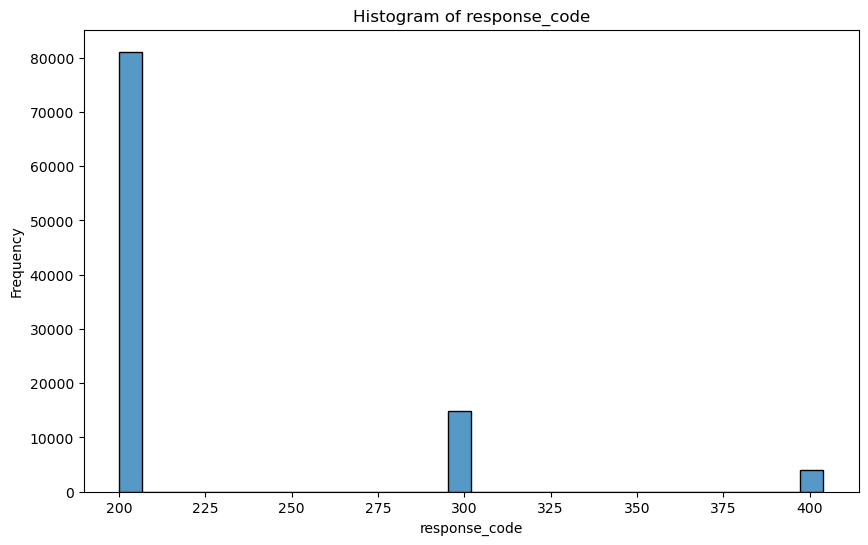

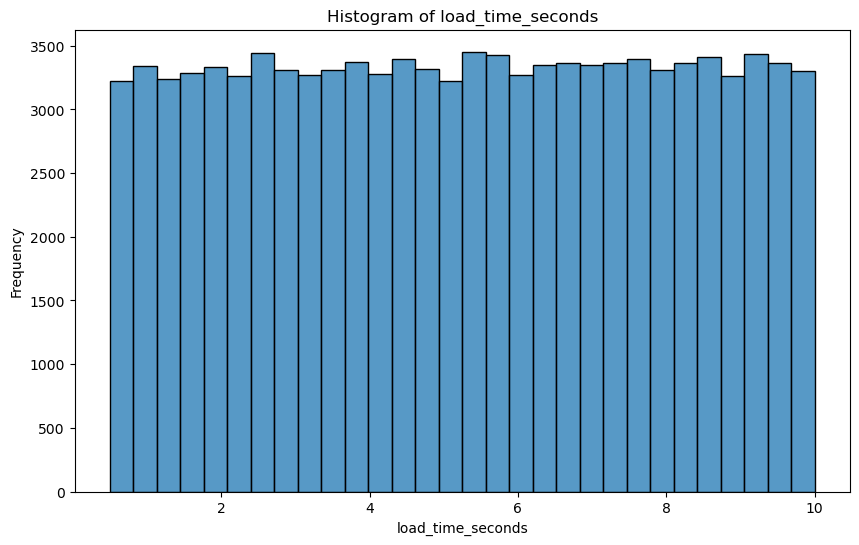

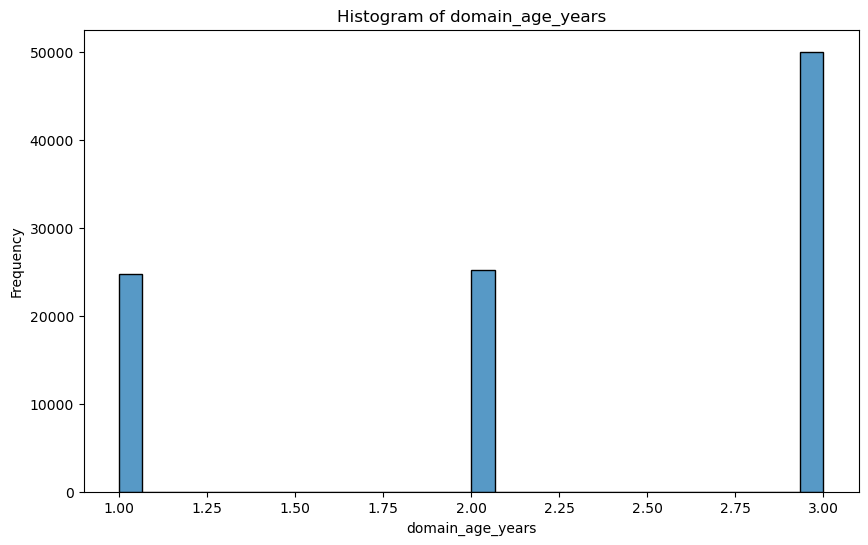

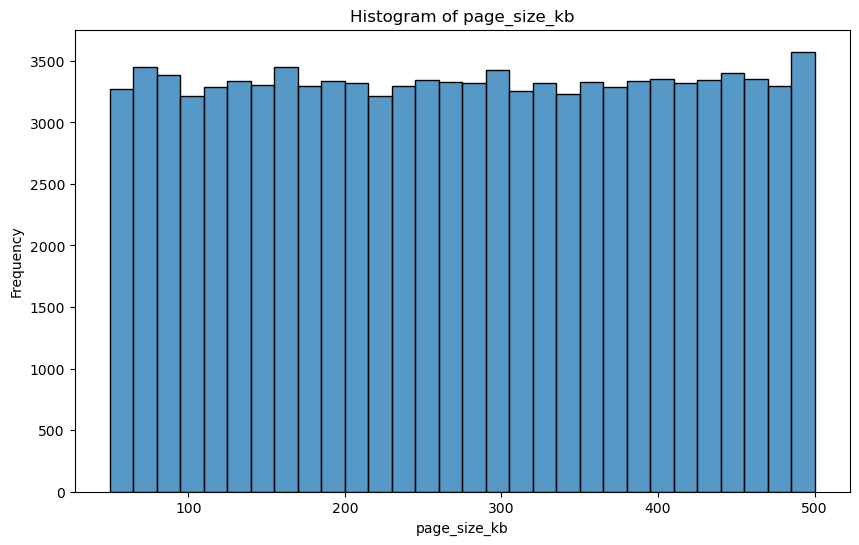

In [25]:
# Select numerical columns
numerical_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Plot histograms for each numerical column
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_df[column], kde=False, bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

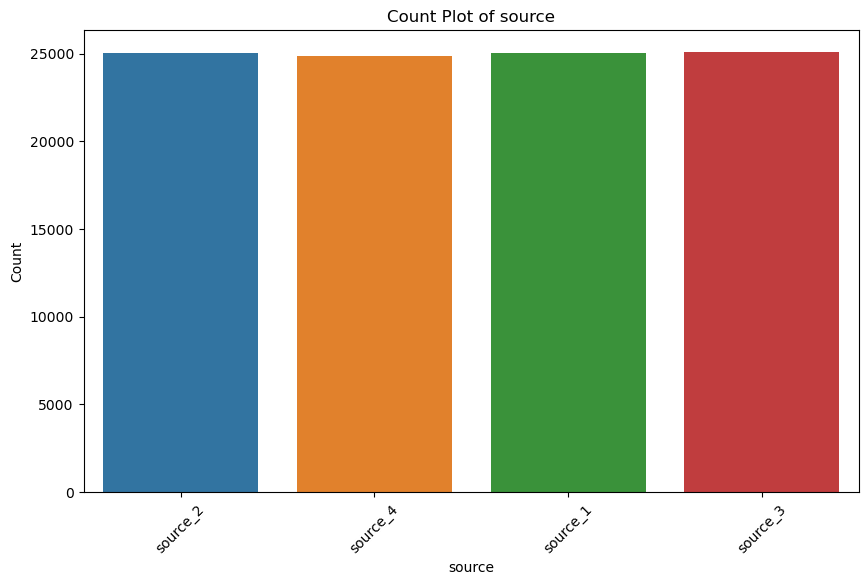

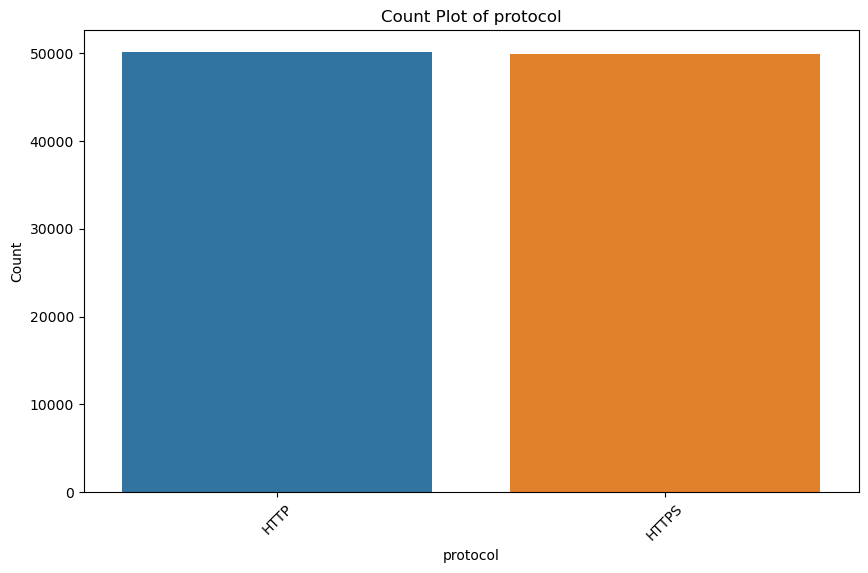

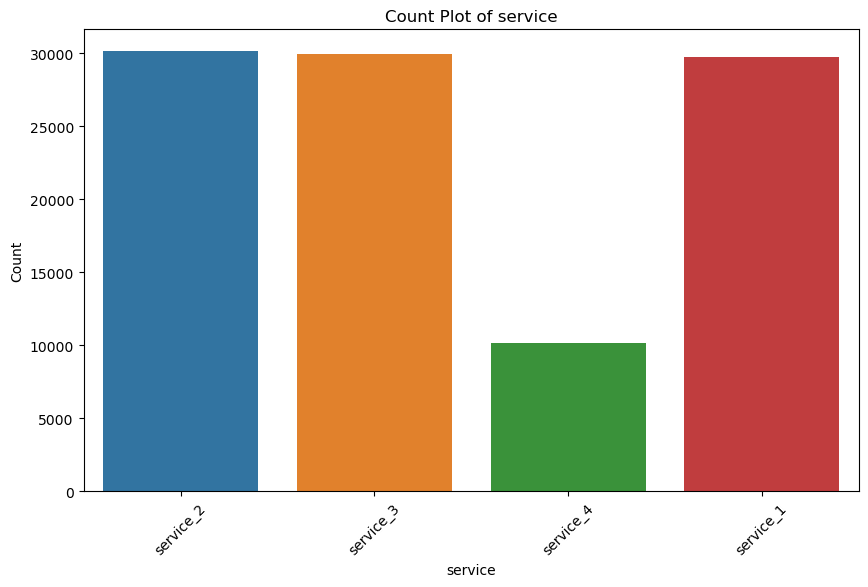

In [26]:
# Select categorical columns
categorical_columns = ['source', 'protocol', 'service']

# Plot count plots for each categorical column
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=merged_df[column])
    plt.title(f'Count Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate labels if necessary
    plt.show()

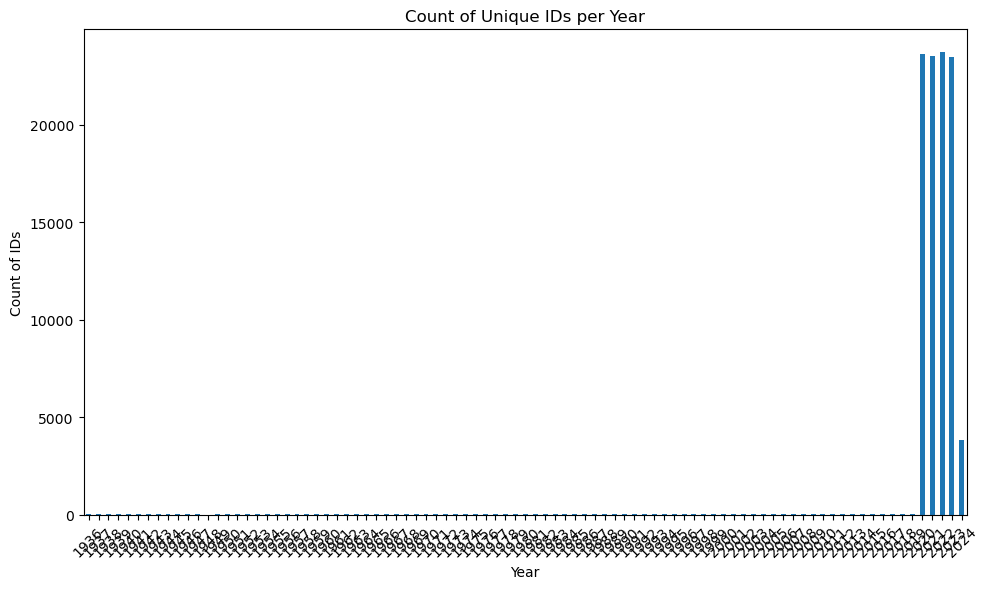

In [27]:
messages['year'] = messages['date'].dt.year

# Group by year and count unique IDs
yearly_counts = messages.groupby('year')['id'].nunique()

# Plot
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='bar')
plt.title('Count of Unique IDs per Year')
plt.xlabel('Year')
plt.ylabel('Count of IDs')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

### Note: 

It appears that the data worth analyzing begins in 2020, as other sources also start from the same year. Therefore, I will exclude the years 1936-2019 from further analysis. Also, I am pretty sure that during World War II, there was no internet.

In [28]:
messages['date'] = pd.to_datetime(messages['date'])

# Filter the DataFrame to keep only dates from 2020-01-01 onwards
messages = merged_df[merged_df['date'] >= '2020-01-01']

## Priority

In [29]:
priority.head()

id   priority  timestamp
0  e81bbb34-b37d-4055-8356-27aa1f179c4d  service_4 2023-12-26
1  5f5d8e39-5539-4503-a07e-a748cc2adffb  service_4 2023-08-28
2  f2667858-92e4-40e7-91e9-df2c32ab4079  service_3 2023-02-26
3  6b99aaf9-847e-45ad-9eb3-8e8448dd0fca  service_3 2020-05-16
4  385c2534-bc68-40f8-985f-d6f39ddb8b9a  service_1 2021-02-03

In [30]:
priority.describe()

/var/folders/4b/y7ccgm795dqf21zwzxsv9wj00000gn/T/ipykernel_21818/2832451816.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  priority.describe()


id   priority            timestamp
count                                 100000     100000               100000
unique                                100000          4                 1520
top     e81bbb34-b37d-4055-8356-27aa1f179c4d  service_3  2023-07-31 00:00:00
freq                                       1      30202                   92
first                                    NaN        NaN  2020-01-01 00:00:00
last                                     NaN        NaN  2024-02-28 00:00:00

In [31]:
null_counts = priority.isnull().sum()
print(null_counts)

id           0
priority     0
timestamp    0
dtype: int64


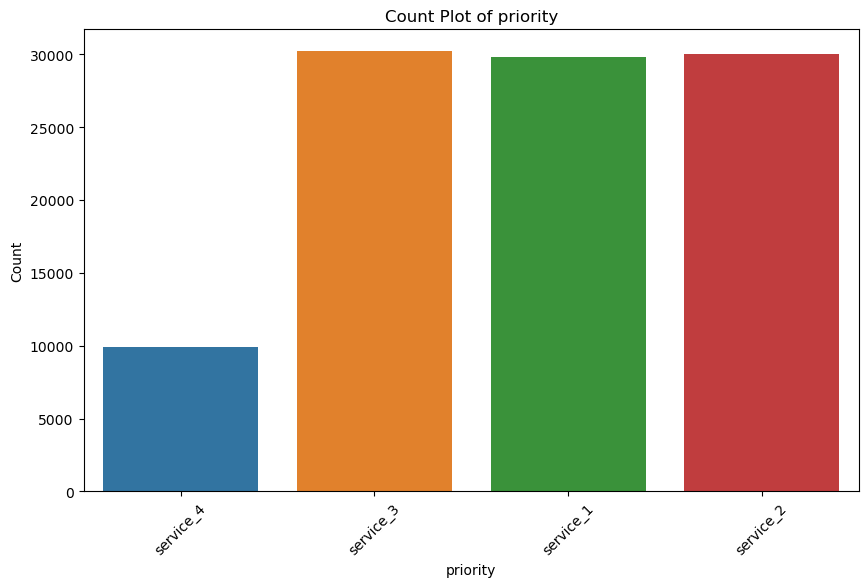

In [32]:
# Select categorical columns
categorical_columns = ['priority']


# Plot count plots for each categorical column
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=priority[column])
    plt.title(f'Count Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate labels if necessary
    plt.show()

## Reputations 

In [33]:
reputations.head()

id reputation_source  reputation_score  \
0  b5ef91f1-2cad-4c68-b150-ab3772f5d998          source_2                87   
1  a06064f8-71d0-44ee-8630-56a81c5ac16f          source_3                57   
2  551fa742-7fc5-42d1-88fa-1a93387f0eb2          source_2                75   
3  99de4aec-7070-4d75-9970-c7d5809b6438          source_3                66   
4  13d3fbb4-bc17-485c-b4f4-266268c7fe83          source_1                70   

  reputation_category reputation_date  
0             neutral      2023-08-20  
1                good      2024-02-05  
2                good      2021-08-05  
3             neutral      2023-02-22  
4                good      2020-04-19

In [34]:
summary_stats = reputations.describe(include='all')

In [35]:
summary_stats

id reputation_source  \
count                                  90000             90000   
unique                                 90000                 4   
top     b5ef91f1-2cad-4c68-b150-ab3772f5d998          source_2   
freq                                       1             27290   
mean                                     NaN               NaN   
std                                      NaN               NaN   
min                                      NaN               NaN   
25%                                      NaN               NaN   
50%                                      NaN               NaN   
75%                                      NaN               NaN   
max                                      NaN               NaN   

        reputation_score reputation_category reputation_date  
count       90000.000000               90000           90000  
unique               NaN                   3            3148  
top                  NaN                good      2024-02-17  
freq                 NaN               54233              86  
mean           50.040756                 NaN             NaN  
std            29.115910                 NaN             NaN  
min             0.000000                 NaN             NaN  
25%            25.000000                 NaN             NaN  
50%            50.000000                 NaN             NaN  
75%            75.000000                 NaN             NaN  
max           100.000000                 NaN             NaN

In [36]:
null_val = reputations.isnull().sum()
print(null_val)

id                     0
reputation_source      0
reputation_score       0
reputation_category    0
reputation_date        0
dtype: int64


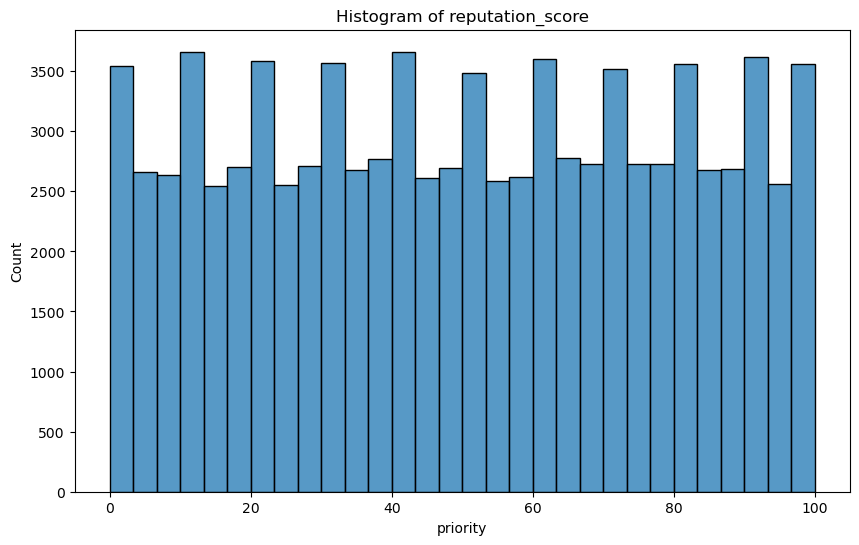

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(reputations['reputation_score'], kde=False, bins=30)  # Adjust bins as needed
plt.title(f'Histogram of reputation_score')
plt.xlabel(column)
plt.show()

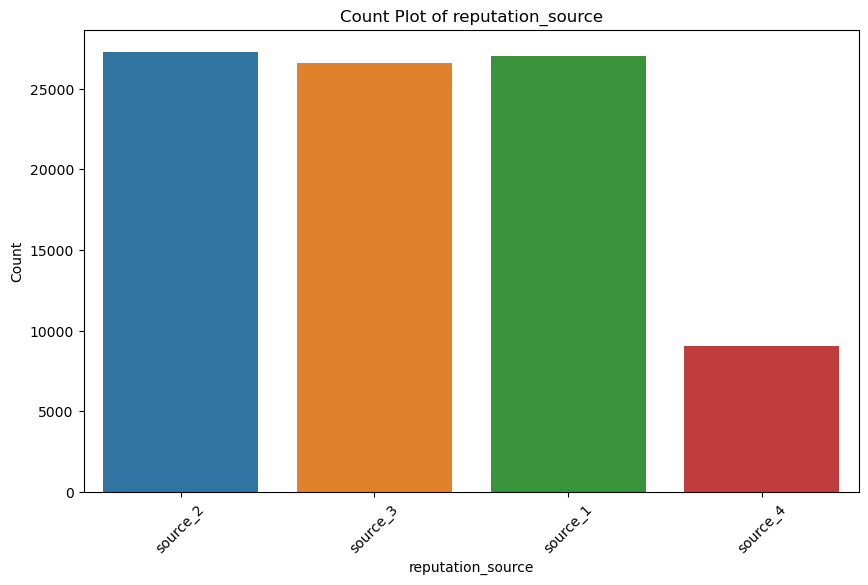

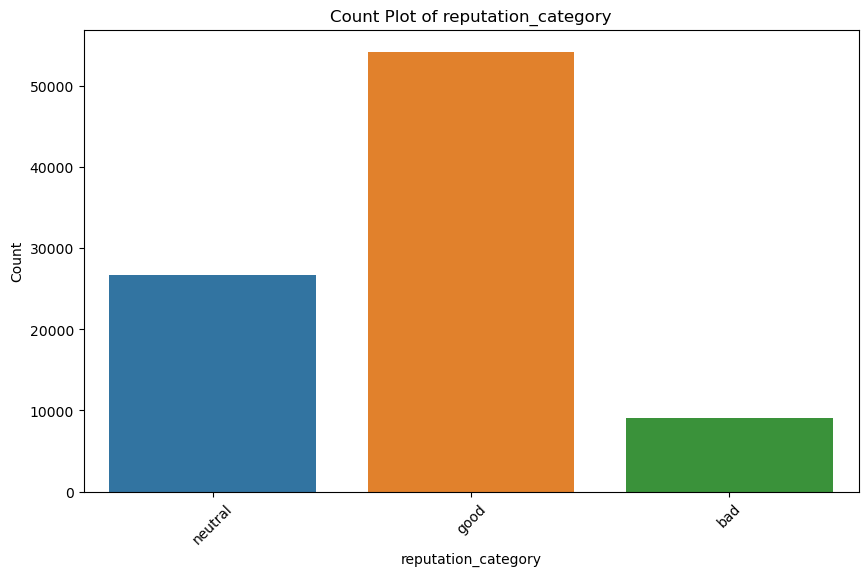

In [38]:
# Select categorical columns
categorical_columns = ['reputation_source', 'reputation_category']


# Plot count plots for each categorical column
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=reputations[column])
    plt.title(f'Count Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate labels if necessary
    plt.show()

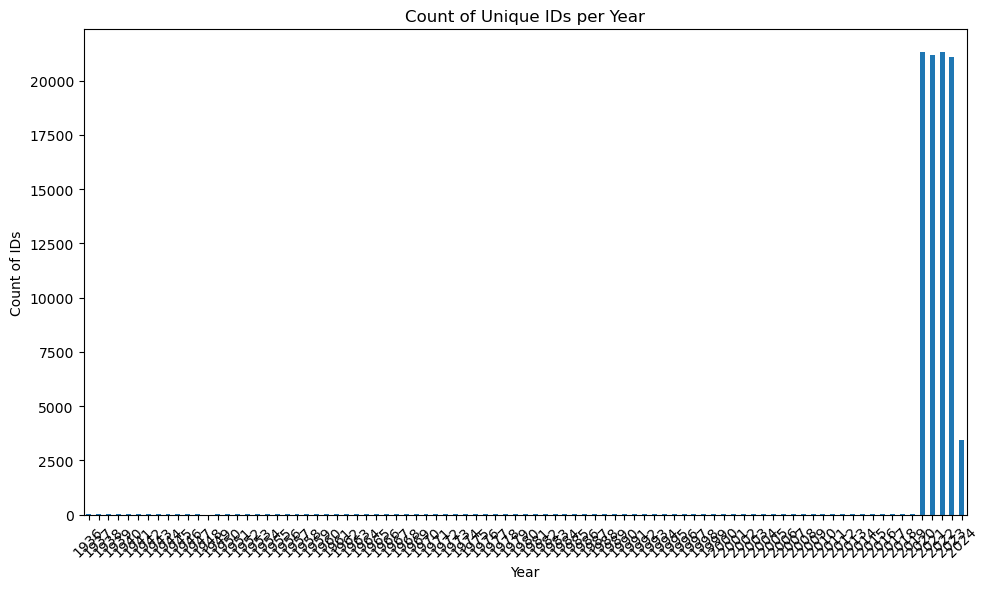

In [39]:
reputations['reputation_date'] = pd.to_datetime(reputations['reputation_date'])
reputations['year'] = reputations['reputation_date'].dt.year

# Group by year and count unique IDs
yearly_counts = reputations.groupby('year')['id'].nunique()

# Plot
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='bar')
plt.title('Count of Unique IDs per Year')
plt.xlabel('Year')
plt.ylabel('Count of IDs')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

### Note: 
This source will be treated as messages, by leaving data starting from 2020.

In [40]:
# Filter the DataFrame to keep only dates from 2020-01-01 onwards
reputations = reputations[reputations['reputation_date'] >= '2020-01-01']

## True Reputations

In [41]:
true_reputations.head()

id true_reputation reputation_source  \
0  356768e7-eb3c-4b0d-8bdd-975ec605e1ec           clean         service_C   
1  33e1be2d-bc22-4771-ac98-f717714a9b5c           clean         service_A   
2  deac4684-3fcc-4159-800a-988d88af475e         unknown         service_B   
3  50f5f3e8-a3a2-491f-baa2-bf6557ee481a         malware         service_D   
4  dbe9ff6e-18ca-41c3-908f-b50a98f28249           clean         service_D   

   timestamp  
0 2020-06-18  
1 2023-04-13  
2 2020-10-18  
3 2022-07-29  
4 2023-03-09

In [42]:
true_reputations.describe()

/var/folders/4b/y7ccgm795dqf21zwzxsv9wj00000gn/T/ipykernel_21818/934628580.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  true_reputations.describe()


id true_reputation  \
count                                  93334           93334   
unique                                 93334               5   
top     356768e7-eb3c-4b0d-8bdd-975ec605e1ec           clean   
freq                                       1           55902   
first                                    NaN             NaN   
last                                     NaN             NaN   

       reputation_source            timestamp  
count              93334                93334  
unique                 4                 1520  
top            service_C  2020-10-28 00:00:00  
freq               28087                   88  
first                NaN  2020-01-01 00:00:00  
last                 NaN  2024-02-28 00:00:00

In [43]:
null_val = true_reputations.isnull().sum()
print(null_val)

id                   0
true_reputation      0
reputation_source    0
timestamp            0
dtype: int64


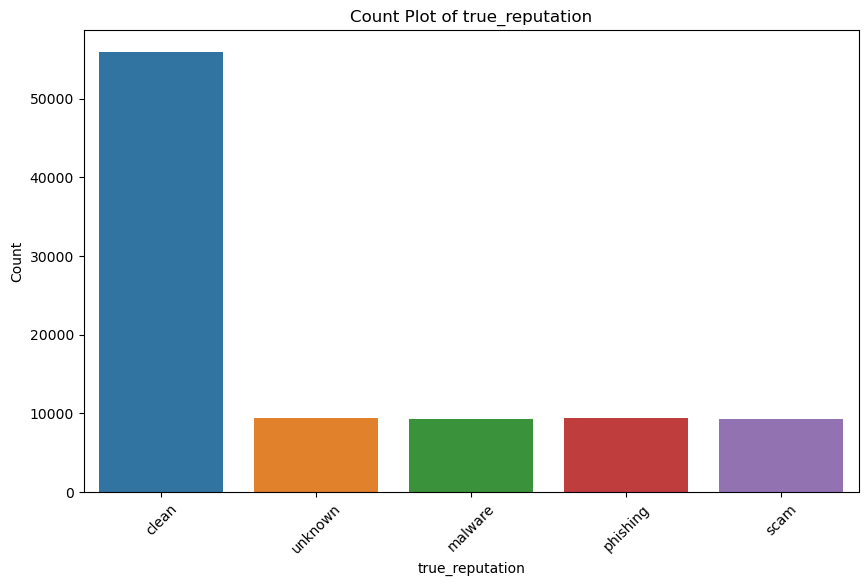

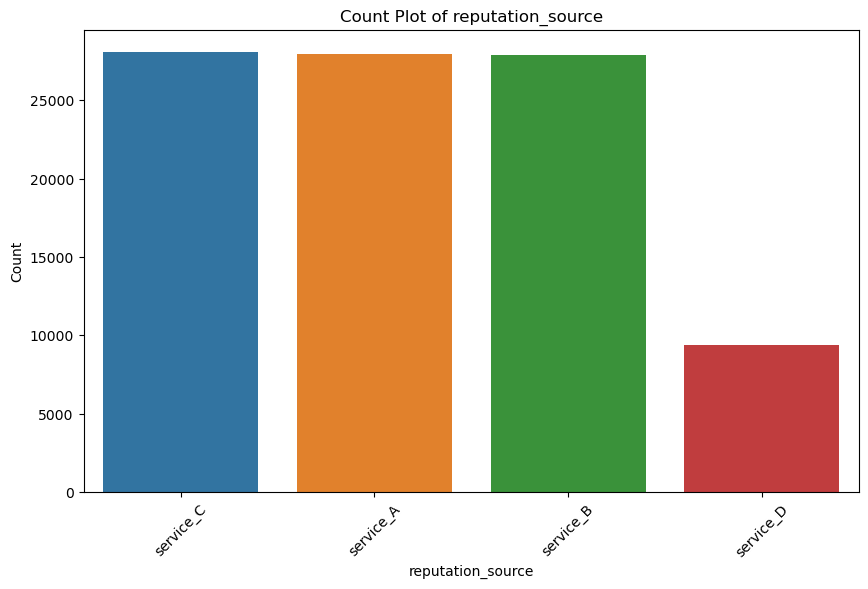

In [44]:
# Select categorical columns
categorical_columns = ['true_reputation', 'reputation_source']

# Plot count plots for each categorical column
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=true_reputations[column])
    plt.title(f'Count Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Part II: Data Investigation

### Q1: Which service deals with the most load time?

In [45]:
merged_df = messages

In [46]:
messages.head()

id             url       date    source  \
0  e4c75faf-2647-499d-bec0-3602b21c17c4    news.mail.ru 2022-12-11  source_2   
1  1a4d5919-5e55-4730-a2b7-dfe46490c03e         rs6.net 2024-02-15  source_4   
2  59d6d211-9533-41de-b290-bc996d042b06  postfinance.ch 2020-04-20  source_1   
3  1fd98cc8-25f7-4328-8764-21e046214e90       libero.it 2020-05-29  source_1   
4  9d2d879a-b9f9-4839-9dab-bd6d96ed8a30      xvideos.es 2022-01-30  source_4   

  protocol  response_code  load_time_seconds  domain_age_years  page_size_kb  \
0     HTTP          200.0               1.87               2.0           252   
1     HTTP          200.0               0.59               2.0           179   
2    HTTPS          200.0               2.10               1.0           252   
3     HTTP          200.0               9.65               2.0           308   
4     HTTP          200.0               9.07               1.0            80   

               redirects    service  
0                  False  service_2  
1                  False  service_2  
2                  False  service_3  
3    [True, pandora.com]  service_4  
4  [True, pravda.com.ua]  service_3

In [47]:
service_load_times = merged_df.groupby('service')['load_time_seconds'].mean()

# Find the service with the highest average load time
service_with_most_load = service_load_times.idxmax()
max_load_time = service_load_times.max()

print(f"The service with the most average load time is {service_with_most_load} with an average load time of {max_load_time} seconds.")


The service with the most average load time is service_1 with an average load time of 5.277680339947225 seconds.


In [48]:
service_load_times

service
service_1    5.277680
service_2    5.270620
service_3    5.262120
service_4    5.237817
Name: load_time_seconds, dtype: float64

In [49]:
service_quartiles = merged_df.groupby('service')['load_time_seconds'].quantile([0.25, 0.50, 0.75]).unstack()

print(service_quartiles)

           0.25  0.50  0.75
service                    
service_1  2.90  5.31  7.65
service_2  2.90  5.26  7.65
service_3  2.90  5.29  7.62
service_4  2.87  5.25  7.64


In [50]:
messages = messages.copy()

messages['date'] = pd.to_datetime(messages['date'])
messages['year_month'] = messages['date'].dt.to_period('M')

monthly_totals = messages.groupby('year_month')['load_time_seconds'].sum()

df_grouped = messages.groupby(['year_month', 'service']).agg({'load_time_seconds':'sum'})
df_grouped['percentage'] = df_grouped['load_time_seconds'] / df_grouped.groupby(level=0)['load_time_seconds'].sum() * 100
df_grouped.reset_index(inplace=True)

In [51]:
# Pivot data for plotting
df_pivoted = df_grouped.pivot(index='year_month', columns='service', values='percentage')

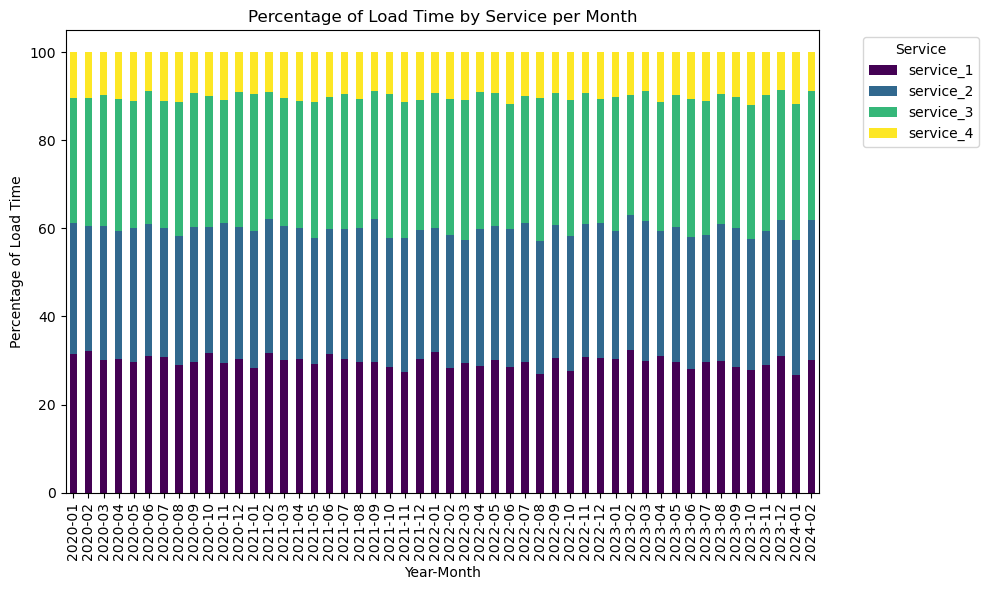

In [52]:
# Plotting the stacked bar chart
ax = df_pivoted.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Percentage of Load Time by Service per Month')
plt.xlabel('Year-Month')
plt.ylabel('Percentage of Load Time')
plt.legend(title='Service', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Convert the x-axis labels to a more readable format
ax.set_xticklabels([x.strftime('%Y-%m') for x in df_pivoted.index.to_timestamp()])

plt.show()

<Figure size 1000x600 with 0 Axes>

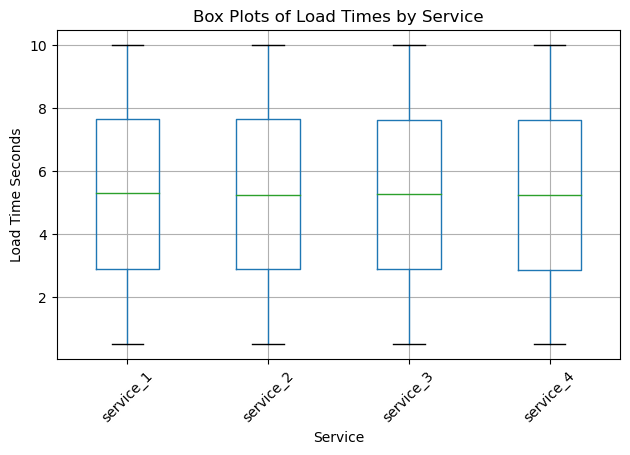

In [53]:
# Generate the box plot
plt.figure(figsize=(10, 6))  
merged_df.boxplot(column='load_time_seconds', by='service')
plt.title('Box Plots of Load Times by Service')  
plt.suptitle('')  
plt.xlabel('Service')  
plt.ylabel('Load Time Seconds')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  

### Performance Consistency
All four services show a good level of consistency as indicated by the similar box sizes and whisker lengths.

### Service Comparison
While the medians and overall ranges are similar, slight variations in the medians might suggest that some services, like **Service_1** and **Service_4**, have slightly higher typical load times.

### Q2: Which services causes the most redirects?

In [54]:
messages['redirected'] = messages['redirects'].apply(lambda x: x[0] if isinstance(x, list) else x)

redirect_counts = messages.groupby('service')['redirected'].sum()

# Identify the service with the most redirects
service_with_most_redirects = redirect_counts.idxmax()
max_redirects = redirect_counts.max()

print(f"The service with the most redirects is {service_with_most_redirects} with {max_redirects} redirects.")

The service with the most redirects is service_3 with 11852 redirects.


In [55]:
redirect_counts

service
service_1    11587
service_2    11839
service_3    11852
service_4     4014
Name: redirected, dtype: int64

In [56]:
messages['redirected'] = messages['redirected'] > 0

# Group by 'service' and calculate the total number of messages and redirects
service_totals = messages.groupby('service').agg(
    total_messages=('redirected', 'size'), 
    total_redirects=('redirected', 'sum')   
)

# Calculate the share of redirects
service_totals['redirect_share'] = service_totals['total_redirects'] / service_totals['total_messages']

print(service_totals[['redirect_share']])

           redirect_share
service                  
service_1        0.397073
service_2        0.400738
service_3        0.402773
service_4        0.401721


### Overview of the Data

- **Service_1**: Approximately 39.71% of messages from this service resulted in redirects.
- **Service_2**: About 40.07% of messages from this service involved redirects.
- **Service_3**: Roughly 40.28% of messages from this service led to redirects.
- **Service_4**: Around 40.17% of messages from this service had redirects.

### Analysis
#### Similarity in Proportions
All four services show very similar shares of redirected messages, with percentages clustering around 40%. This similarity suggests that the likelihood of encountering a redirect is fairly consistent across these services.

#### Slight Variations
While the differences are minimal, `service_3` exhibits the highest redirect share, albeit only slightly higher than the others. Conversely, `service_1` has the lowest proportion of redirects, but again, the difference is marginal.

### Q3: Which source has the most incorrect reputations?

In [58]:
# Check the unique categories
print(reputations['reputation_category'].unique())

['neutral' 'good' 'bad']


In [59]:
# Check the unique categories of true reputaions
print(true_reputations['true_reputation'].unique())

['clean' 'unknown' 'malware' 'phishing' 'scam']


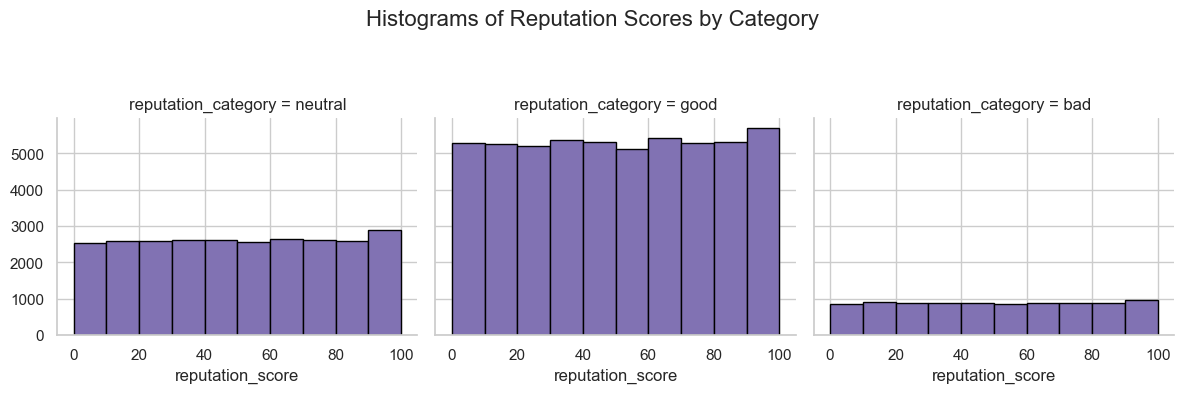

In [60]:
sns.set(style='whitegrid')

g = sns.FacetGrid(reputations, col="reputation_category", col_wrap=3, height=4)
g.map(plt.hist, 'reputation_score', bins=10, color='m', edgecolor='black')

g.fig.subplots_adjust(top=0.85)  
g.fig.suptitle('Histograms of Reputation Scores by Category', fontsize=16) 
g.fig.tight_layout(rect=[0, 0, 1, 0.9])  

plt.show()

I assumed that there would be different ranges of reputation scores per category, but apparently, this is not the case. Therefore, I will need to map predicted reputations to true reputations to be able to calculate the most incorrect source for reputations.


In [61]:
# Reputations map
rep_map = {
    'good': ['clean'],
    'neutral': ['unknown', 'clean'],
    'bad': ['phishing','scam','malware']
}

In [62]:
# List of DataFrames to merge
dfs = [messages, priority, reputations, true_reputations]

# Reduce function to merge all DataFrames on id using a left join
join_df = reduce(lambda left, right: pd.merge(left, right, on='id', how='left'), dfs)

In [63]:
join_df.head()

id             url       date    source  \
0  e4c75faf-2647-499d-bec0-3602b21c17c4    news.mail.ru 2022-12-11  source_2   
1  1a4d5919-5e55-4730-a2b7-dfe46490c03e         rs6.net 2024-02-15  source_4   
2  59d6d211-9533-41de-b290-bc996d042b06  postfinance.ch 2020-04-20  source_1   
3  1fd98cc8-25f7-4328-8764-21e046214e90       libero.it 2020-05-29  source_1   
4  9d2d879a-b9f9-4839-9dab-bd6d96ed8a30      xvideos.es 2022-01-30  source_4   

  protocol  response_code  load_time_seconds  domain_age_years  page_size_kb  \
0     HTTP          200.0               1.87               2.0           252   
1     HTTP          200.0               0.59               2.0           179   
2    HTTPS          200.0               2.10               1.0           252   
3     HTTP          200.0               9.65               2.0           308   
4     HTTP          200.0               9.07               1.0            80   

               redirects  ...   priority timestamp_x  reputation_source_x  \
0                  False  ...  service_3  2020-08-12                  NaN   
1                  False  ...  service_3  2021-08-14             source_2   
2                  False  ...  service_1  2021-06-26             source_2   
3    [True, pandora.com]  ...  service_3  2022-10-13             source_3   
4  [True, pravda.com.ua]  ...  service_2  2021-12-07             source_2   

  reputation_score reputation_category reputation_date    year  \
0              NaN                 NaN             NaT     NaN   
1             57.0                good      2024-02-15  2024.0   
2             32.0                good      2020-04-20  2020.0   
3             35.0                good      2020-05-29  2020.0   
4              8.0             neutral      2022-01-30  2022.0   

  true_reputation reputation_source_y  timestamp_y  
0           clean           service_C   2022-02-26  
1           clean           service_C   2020-11-24  
2           clean           service_A   2023-01-25  
3            scam           service_A   2022-03-01  
4           clean           service_C   2022-12-09  

[5 rows x 23 columns]

In [64]:
filtered_df = join_df.dropna(subset=['reputation_category', 'true_reputation'])

In [65]:
def is_correct(category, reputation, mapping):
    """
    Determines if the given reputation matches any of the acceptable reputations
    within a specified category according to a provided mapping.

    Args:
        category (str): The category to which the reputation is supposed to belong.
        reputation (str): The reputation value to be checked against the mapping.
        mapping (dict): A dictionary mapping categories to lists of acceptable
                        reputation values.

    Returns:
        bool: True if the reputation is found within the list associated with
              the category in the mapping. False otherwise, including when the
              category is not found in the mapping.
    """
    if category in mapping:
        return reputation in mapping[category]
    return False 

In [66]:
# Apply the correctness checking function
filtered_df['is_correct'] = filtered_df.apply(lambda row: is_correct(row['reputation_category'], row['true_reputation'], rep_map), axis=1)

/var/folders/4b/y7ccgm795dqf21zwzxsv9wj00000gn/T/ipykernel_21818/19317223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['is_correct'] = filtered_df.apply(lambda row: is_correct(row['reputation_category'], row['true_reputation'], rep_map), axis=1)


In [67]:
# Calculate incorrect proportions
incorrect_counts = filtered_df.groupby('reputation_source_x')['is_correct'].apply(lambda x: (x == False).sum())
total_counts = filtered_df.groupby('reputation_source_x').size()

# Calculate proportion of incorrect reputations
incorrect_proportions = incorrect_counts / total_counts

# Find the source with the highest rate of incorrect reputations
most_incorrect_source = incorrect_proportions.idxmax()
print(f"The source with the most incorrect reputations is {most_incorrect_source} with a proportion of {incorrect_proportions[most_incorrect_source]:.2f} incorrect.")

The source with the most incorrect reputations is source_1 with a proportion of 0.40 incorrect.


In [68]:
incorrect_proportions

reputation_source_x
source_1    0.400844
source_2    0.397738
source_3    0.398797
source_4    0.398719
dtype: float64

### Overview of the Data
- **source_1**: Approximately 40.08% of the reputation assessments made by this source were incorrect.
- **source_2**: About 39.77% of the reputation assessments from this source were incorrect.
- **source_3**: Roughly 39.88% of the assessments made by this source were incorrect.
- **source_4**: Around 39.87% of the reputation assessments from this source were incorrect.

### Analysis

#### Consistency Across Sources
All four sources have incorrect reputation proportions that are quite close to each other, ranging narrowly between approximately 39.77% and 40.08%. This suggests that there is a relatively consistent level of accuracy (or inaccuracy) across these sources when assessing reputations.

#### Marginal Differences
- **source_1** shows the highest rate of incorrect reputations at just over 40%. While this is the highest among the four, the difference is very slight when compared to the other sources.
- The other three sources (**source_2**, **source_3**, and **source_4**) have very similar percentages of incorrect reputations, all falling within a tight range around 39.8%, indicating minimal variability in their performance.

### Q4: Are there any meaningful correlations?

In [69]:
def plot_numerical_correlation_matrix(df):
    correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Variables')
    plt.show()

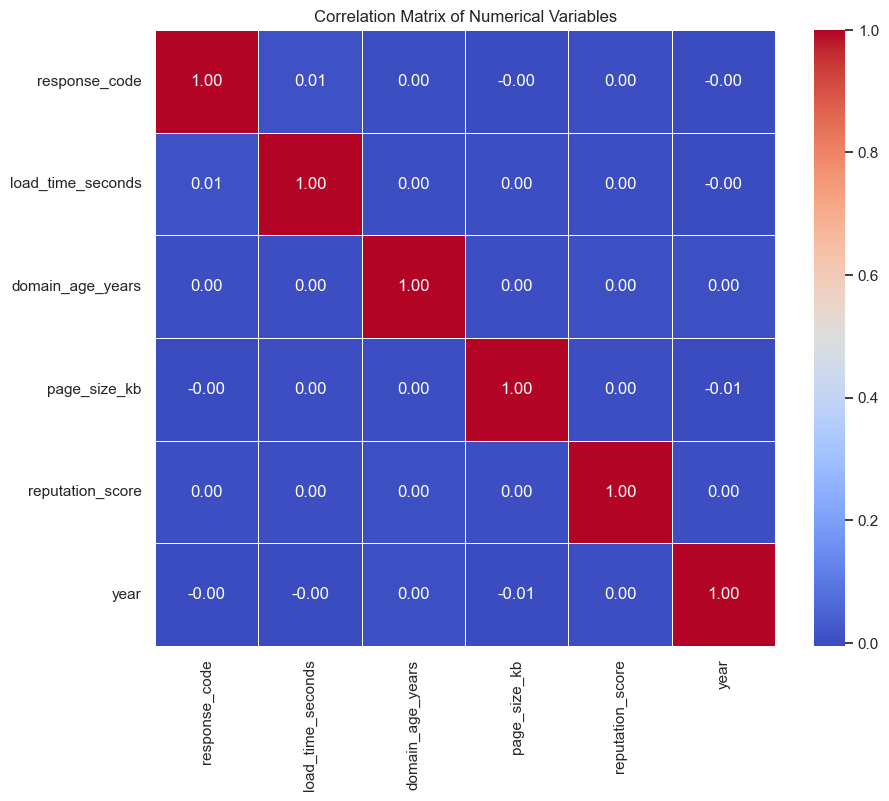

In [70]:
plot_numerical_correlation_matrix(filtered_df)

In [71]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

def analyze_categorical_dependency(df, cat_col):
    categorical_columns = cat_col
    results = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
    
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                results.loc[col1, col2] = 1.0
            else:
                results.loc[col1, col2] = cramers_v(df[col1], df[col2])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(results.astype(float), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title("Cramér's V Between Categorical Variables")
    plt.show()

In [72]:
cat_col = ['source',
           'protocol',
           'priority',
           'reputation_source_x',
           'reputation_category',
           'true_reputation',
           'reputation_source_y']

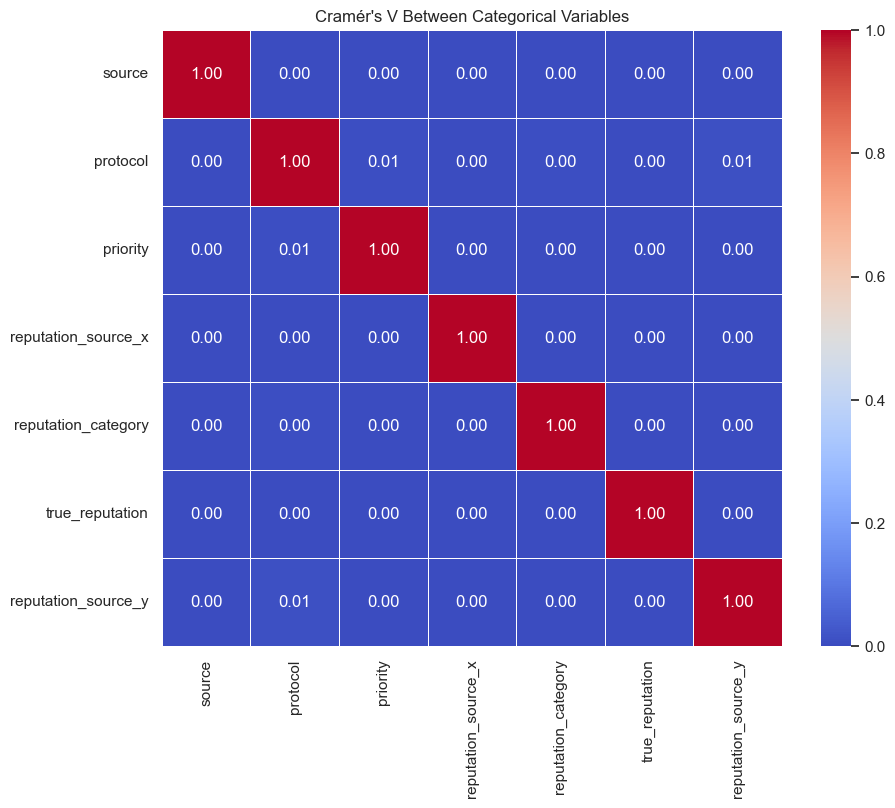

In [73]:
analyze_categorical_dependency(filtered_df, cat_col)

It apears that thera are no lienear correlations on given dataset.

## Finding the Most Recent URL Reputation

In [74]:
# List of DataFrames to merge
dfs = [messages, priority, reputations, true_reputations]

# Reduce function to merge all DataFrames on id using a left join
join_df = reduce(lambda left, right: pd.merge(left, right, on='id', how='left'), dfs)

In [75]:
join_df.head()

id             url       date    source  \
0  e4c75faf-2647-499d-bec0-3602b21c17c4    news.mail.ru 2022-12-11  source_2   
1  1a4d5919-5e55-4730-a2b7-dfe46490c03e         rs6.net 2024-02-15  source_4   
2  59d6d211-9533-41de-b290-bc996d042b06  postfinance.ch 2020-04-20  source_1   
3  1fd98cc8-25f7-4328-8764-21e046214e90       libero.it 2020-05-29  source_1   
4  9d2d879a-b9f9-4839-9dab-bd6d96ed8a30      xvideos.es 2022-01-30  source_4   

  protocol  response_code  load_time_seconds  domain_age_years  page_size_kb  \
0     HTTP          200.0               1.87               2.0           252   
1     HTTP          200.0               0.59               2.0           179   
2    HTTPS          200.0               2.10               1.0           252   
3     HTTP          200.0               9.65               2.0           308   
4     HTTP          200.0               9.07               1.0            80   

               redirects  ...   priority timestamp_x  reputation_source_x  \
0                  False  ...  service_3  2020-08-12                  NaN   
1                  False  ...  service_3  2021-08-14             source_2   
2                  False  ...  service_1  2021-06-26             source_2   
3    [True, pandora.com]  ...  service_3  2022-10-13             source_3   
4  [True, pravda.com.ua]  ...  service_2  2021-12-07             source_2   

  reputation_score reputation_category reputation_date    year  \
0              NaN                 NaN             NaT     NaN   
1             57.0                good      2024-02-15  2024.0   
2             32.0                good      2020-04-20  2020.0   
3             35.0                good      2020-05-29  2020.0   
4              8.0             neutral      2022-01-30  2022.0   

  true_reputation reputation_source_y  timestamp_y  
0           clean           service_C   2022-02-26  
1           clean           service_C   2020-11-24  
2           clean           service_A   2023-01-25  
3            scam           service_A   2022-03-01  
4           clean           service_C   2022-12-09  

[5 rows x 23 columns]

In [76]:
join_df['date'] = pd.to_datetime(join_df['date'])
join_df['timestamp_x'] = pd.to_datetime(join_df['timestamp_x'])

# Sort by date in descending order to get the latest records on top
df_sorted = join_df.sort_values(by=['url', 'service', 'date'], ascending=[True, True, False])

# Drop duplicates to keep only the latest per service for each URL
df_latest_per_service_per_url = df_sorted.drop_duplicates(subset=['url', 'service'])

# Checking the dates
df_validated = df_latest_per_service_per_url[df_latest_per_service_per_url['date'] <= df_latest_per_service_per_url['timestamp_x']]

In [77]:
# Chek on specific url
df_validated[df_validated['url'] == 'fon.bet']

id      url       date    source  \
25961  b1530185-b1e0-4b22-a3a8-eb0e59fabd3d  fon.bet 2023-03-13  source_3   

      protocol  response_code  load_time_seconds  domain_age_years  \
25961    HTTPS          200.0               9.06               2.0   

       page_size_kb                   redirects  ...   priority timestamp_x  \
25961           384  [True, shopping.naver.com]  ...  service_3  2023-08-30   

       reputation_source_x reputation_score reputation_category  \
25961             source_1             32.0                good   

      reputation_date    year true_reputation reputation_source_y  timestamp_y  
25961      2023-03-13  2023.0         unknown           service_B   2020-05-26  

[1 rows x 23 columns]

### Approach #2 dealing with missing data

In [78]:
def custom_agg(x):
    """
    Aggregates a grouped DataFrame by backfilling missing values and then 
    selecting the first non-null value for each column.

    Parameters:
    - x (DataFrame): The DataFrame segment passed by the groupby.apply() method.

    Returns:
    - DataFrame: A single-row DataFrame with the first complete record after backfilling.
    """
    return x.bfill().iloc[0]


In [79]:
# Group by url and service, and apply the custom aggregation function
df_aggregated = df_sorted.groupby(['url', 'service']).apply(custom_agg).reset_index(drop=True)

In [80]:
# Check the dates
df_validated = df_aggregated[df_aggregated['date'] <= df_aggregated['timestamp_x']]

In [81]:
df_validated.head()

id            url       date    source  \
2   23104432-7a56-4f19-82be-3c93c1283c79       0hpx.xyz 2023-10-27  source_2   
15  786b6737-5a40-4cec-8ca3-ec0f5fd2795b        163.com 2021-10-29  source_4   
37  413117e8-f6aa-4015-af60-2d771523e232  247sports.com 2022-09-19  source_4   
40  f7c142f1-185f-425e-8308-70181922fa75     24h.com.vn 2022-10-02  source_2   
49  4c13b684-950e-45e6-a747-04f10cd20cd2       2mdn.net 2023-04-14  source_2   

   protocol  response_code  load_time_seconds  domain_age_years  page_size_kb  \
2      HTTP          200.0               9.42               2.0           279   
15    HTTPS          200.0               3.22               1.0           157   
37     HTTP          200.0               5.96               1.0           460   
40     HTTP          200.0               6.91               3.0           470   
49     HTTP          301.0               9.74               2.0           369   

            redirects  ...   priority timestamp_x  reputation_source_x  \
2               False  ...  service_1  2023-12-19             source_3   
15  [True, googl.com]  ...  service_2  2022-07-26             source_2   
37              False  ...  service_2  2022-09-23             source_3   
40              False  ...  service_2  2023-05-03             source_3   
49              False  ...  service_2  2023-08-13             source_2   

   reputation_score reputation_category reputation_date    year  \
2              26.0                good      2023-10-27  2023.0   
15             62.0                good      2021-10-29  2021.0   
37             18.0             neutral      2022-09-19  2022.0   
40             44.0             neutral      2022-10-02  2022.0   
49             31.0                good      2023-04-14  2023.0   

   true_reputation reputation_source_y  timestamp_y  
2            clean           service_D   2024-01-17  
15        phishing           service_B   2020-05-09  
37           clean           service_A   2021-07-28  
40         unknown           service_B   2022-05-12  
49           clean           service_C   2022-06-08  

[5 rows x 23 columns]

In [82]:
# Chek on specific url
df_validated[df_validated['url'] == 'fon.bet']

id      url       date    source  \
2617  b1530185-b1e0-4b22-a3a8-eb0e59fabd3d  fon.bet 2023-03-13  source_3   

     protocol  response_code  load_time_seconds  domain_age_years  \
2617    HTTPS          200.0               9.06               2.0   

      page_size_kb                   redirects  ...   priority timestamp_x  \
2617           384  [True, shopping.naver.com]  ...  service_3  2023-08-30   

      reputation_source_x reputation_score reputation_category  \
2617             source_1             32.0                good   

     reputation_date    year true_reputation reputation_source_y  timestamp_y  
2617      2023-03-13  2023.0         unknown           service_B   2020-05-26  

[1 rows x 23 columns]

## Step-by-Step Logic Breakdown

### Sorting the Data:
The data is sorted by 'url', 'service', and 'date' in ascending order. This ensures that when processing each group (each unique combination of URL and service), the earliest messages are encountered first, and the most recent messages are encountered last. 

### Grouping and Custom Aggregation:
After sorting, the data is grouped by 'url' and 'service'. This grouping is crucial because it allows the analysis to focus on each service's interaction with a specific URL, isolating these interactions from those of other services or URLs.

A custom aggregation function, `custom_agg`, is applied to each group. This function uses the `bfill()` method to fill missing values in each column of the group's DataFrame with the next available non-null value. This operation is known as backfilling. The idea is that if an earlier message (in chronological order within the group) lacks certain data but a later message contains this data, the later data will fill the earlier missing data points.

### Selection of the Most Complete Record:
Once backfilling is complete, the `iloc[0]` operation is used to select the first record of the now filled DataFrame group. Because of the previous backfilling, this record will be the most complete version, containing the earliest non-null values filled forward from subsequent messages. This record effectively represents the most recent and comprehensive view of the interaction with that URL by that service, capturing all known updates.

### Verification Against Timestamps:
Ensure that the records used are not only the most recent per URL and service but also align with priority updates and ensures relevancy.

In [85]:
# Final data set
df_validated

id            url       date  \
2     23104432-7a56-4f19-82be-3c93c1283c79       0hpx.xyz 2023-10-27   
15    786b6737-5a40-4cec-8ca3-ec0f5fd2795b        163.com 2021-10-29   
37    413117e8-f6aa-4015-af60-2d771523e232  247sports.com 2022-09-19   
40    f7c142f1-185f-425e-8308-70181922fa75     24h.com.vn 2022-10-02   
49    4c13b684-950e-45e6-a747-04f10cd20cd2       2mdn.net 2023-04-14   
...                                    ...            ...        ...   
8616  a0a57cb4-fddd-464e-a99c-202c22553248    zivuhh.buzz 2023-11-09   
8624  52914f4d-7eaf-47da-b23d-47b27bab6b06        zoom.us 2023-02-18   
8631  6128700c-9d11-4e20-ba8c-aad956b14c2c   zoominfo.com 2022-04-04   
8633  a42b4fe0-6693-40f7-9a8c-f027fd0bfd5e      zopim.com 2024-01-01   
8643  248bdb3f-10da-4415-b74a-0c679332d524       zqtk.net 2022-09-09   

        source protocol  response_code  load_time_seconds  domain_age_years  \
2     source_2     HTTP          200.0               9.42               2.0   
15    source_4    HTTPS          200.0               3.22               1.0   
37    source_4     HTTP          200.0               5.96               1.0   
40    source_2     HTTP          200.0               6.91               3.0   
49    source_2     HTTP          301.0               9.74               2.0   
...        ...      ...            ...                ...               ...   
8616  source_3     HTTP          200.0               7.56               3.0   
8624  source_3     HTTP          200.0               5.47               3.0   
8631  source_2    HTTPS          200.0               0.60               3.0   
8633  source_3     HTTP          200.0               0.77               1.0   
8643  source_4     HTTP          200.0               1.76               3.0   

      page_size_kb              redirects  ...   priority timestamp_x  \
2              279                  False  ...  service_1  2023-12-19   
15             157      [True, googl.com]  ...  service_2  2022-07-26   
37             460                  False  ...  service_2  2022-09-23   
40             470                  False  ...  service_2  2023-05-03   
49             369                  False  ...  service_2  2023-08-13   
...            ...                    ...  ...        ...         ...   
8616           404                  False  ...  service_3  2024-01-31   
8624           256  [True, configcat.com]  ...  service_1  2023-08-28   
8631            55                  False  ...  service_2  2022-11-24   
8633           342                  False  ...  service_1  2024-02-04   
8643           434                  False  ...  service_2  2023-04-20   

      reputation_source_x reputation_score reputation_category  \
2                source_3             26.0                good   
15               source_2             62.0                good   
37               source_3             18.0             neutral   
40               source_3             44.0             neutral   
49               source_2             31.0                good   
...                   ...              ...                 ...   
8616             source_2             67.0                 bad   
8624             source_3             14.0             neutral   
8631             source_2             16.0                good   
8633             source_3             56.0             neutral   
8643             source_2              2.0                good   

     reputation_date    year true_reputation reputation_source_y  timestamp_y  
2         2023-10-27  2023.0           clean           service_D   2024-01-17  
15        2021-10-29  2021.0        phishing           service_B   2020-05-09  
37        2022-09-19  2022.0           clean           service_A   2021-07-28  
40        2022-10-02  2022.0         unknown           service_B   2022-05-12  
49        2023-04-14  2023.0           clean           service_C   2022-06-08  
...              ...     ...             ...                 ...          ..